# Import Package

In [1]:
# import common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
# import PyTorch's common packages
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [3]:
# import data
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


C:\Users\HP\miniconda3\envs\jcopdl\lib\site-packages\pandas\plotting\_matplotlib\core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


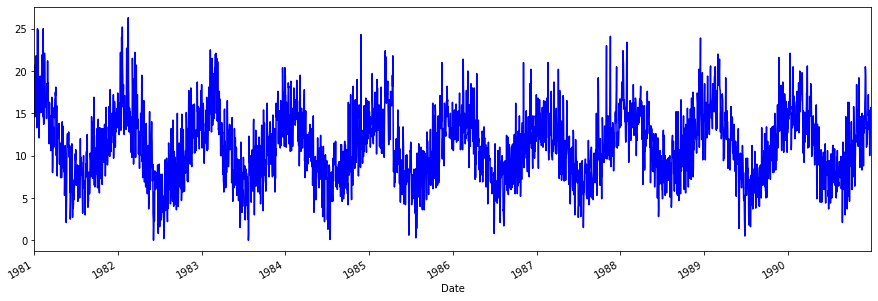

In [4]:
# plot data
df.Temp.plot(figsize=(15, 5), colors="b")

# Dataset Splitting

In [5]:
# split data time series
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset & Dataloader

In [6]:
# import packages
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [7]:
# pipeline
seq_len = 14
bs = 32

# train
train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

# test
test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Architecture and Config

In [8]:
# RNN Block architecture
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
       
    # feed forward
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [9]:
# save config
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0
})

# Training Preparation -> MCOC

In [10]:
# Model
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)

# Criterion
criterion = nn.MSELoss(reduction="mean")

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Callback
callback = Callback(model, config, outdir="model/rnn")

# Training

In [11]:
# loop func
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 122.5995 | Test_cost  = 106.9014 | 




Epoch     2
Train_cost  = 89.0404 | Test_cost  = 81.2127 | 




Epoch     3
Train_cost  = 69.1972 | Test_cost  = 66.9517 | 




Epoch     4
Train_cost  = 57.9996 | Test_cost  = 58.1949 | 




Epoch     5
Train_cost  = 50.6658 | Test_cost  = 51.5543 | 




Epoch     6
Train_cost  = 44.7954 | Test_cost  = 45.7818 | 




Epoch     7
Train_cost  = 39.6405 | Test_cost  = 40.7342 | 




Epoch     8
Train_cost  = 35.3314 | Test_cost  = 36.6603 | 




Epoch     9
Train_cost  = 31.8372 | Test_cost  = 33.2428 | 




Epoch    10
Train_cost  = 28.9137 | Test_cost  = 30.3494 | 




Epoch    11
Train_cost  = 26.4663 | Test_cost  = 27.9113 | 




Epoch    12
Train_cost  = 24.4311 | Test_cost  = 25.8692 | 




Epoch    13
Train_cost  = 22.7519 | Test_cost  = 24.1695 | 




Epoch    14
Train_cost  = 21.3774 | Test_cost  = 22.7636 | 




Epoch    15
Train_cost  = 20.2617 | Test_cost  = 21.6080 | 




Epoch    16
Train_cost  = 19.3636 | Test_cost  = 20.6637 | 




Epoch    17
Train_cost  = 18.6470 | Test_cost  = 19.8966 | 




Epoch    18
Train_cost  = 18.0802 | Test_cost  = 19.2769 | 




Epoch    19
Train_cost  = 17.6357 | Test_cost  = 18.7787 | 




Epoch    20
Train_cost  = 17.2901 | Test_cost  = 18.3799 | 


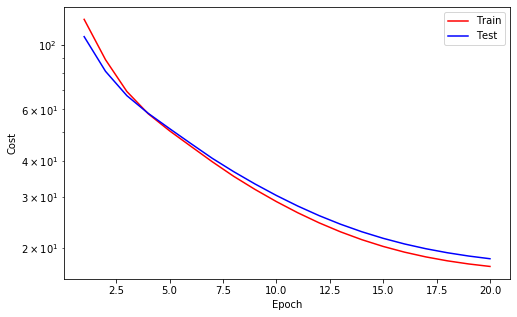



Epoch    21
Train_cost  = 17.0237 | Test_cost  = 18.0619 | 




Epoch    22
Train_cost  = 16.8199 | Test_cost  = 17.8090 | 




Epoch    23
Train_cost  = 16.6650 | Test_cost  = 17.6083 | 




Epoch    24
Train_cost  = 16.5481 | Test_cost  = 17.4491 | 




Epoch    25
Train_cost  = 16.4601 | Test_cost  = 17.3228 | 




Epoch    26
Train_cost  = 16.3940 | Test_cost  = 17.2224 | 




Epoch    27
Train_cost  = 16.3443 | Test_cost  = 17.1423 | 




Epoch    28
Train_cost  = 16.3065 | Test_cost  = 17.0780 | 




Epoch    29
Train_cost  = 16.2774 | Test_cost  = 17.0259 | 




Epoch    30
Train_cost  = 16.2542 | Test_cost  = 16.9831 | 




Epoch    31
Train_cost  = 16.2349 | Test_cost  = 16.9472 | 




Epoch    32
Train_cost  = 16.2176 | Test_cost  = 16.9160 | 




Epoch    33
Train_cost  = 16.2008 | Test_cost  = 16.8874 | 




Epoch    34
Train_cost  = 16.1825 | Test_cost  = 16.8587 | 




Epoch    35
Train_cost  = 16.1598 | Test_cost  = 16.8255 | 




Epoch    36
Train_cost  = 16.1261 | Test_cost  = 16.7765 | 




Epoch    37
Train_cost  = 16.0630 | Test_cost  = 16.6735 | 




Epoch    38
Train_cost  = 15.8979 | Test_cost  = 16.3479 | 




Epoch    39
Train_cost  = 15.2890 | Test_cost  = 15.3155 | 




Epoch    40
Train_cost  = 14.3118 | Test_cost  = 14.9411 | 


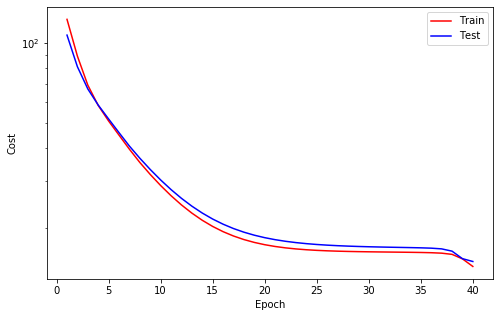



Epoch    41
Train_cost  = 13.5576 | Test_cost  = 14.0191 | 




Epoch    42
Train_cost  = 12.9313 | Test_cost  = 13.3086 | 




Epoch    43
Train_cost  = 12.2747 | Test_cost  = 12.5013 | 




Epoch    44
Train_cost  = 11.6714 | Test_cost  = 11.7491 | 




Epoch    45
Train_cost  = 11.0900 | Test_cost  = 11.1766 | 




Epoch    46
Train_cost  = 10.6904 | Test_cost  = 10.6506 | 




Epoch    47
Train_cost  = 10.2987 | Test_cost  = 10.2136 | 




Epoch    48
Train_cost  = 9.9449 | Test_cost  = 9.8250 | 




Epoch    49
Train_cost  = 9.6522 | Test_cost  = 9.4474 | 




Epoch    50
Train_cost  = 9.3656 | Test_cost  = 9.1214 | 




Epoch    51
Train_cost  = 9.1150 | Test_cost  = 8.8355 | 




Epoch    52
Train_cost  = 8.9074 | Test_cost  = 8.5707 | 




Epoch    53
Train_cost  = 8.7177 | Test_cost  = 8.3349 | 




Epoch    54
Train_cost  = 8.5427 | Test_cost  = 8.1296 | 




Epoch    55
Train_cost  = 8.3888 | Test_cost  = 7.9448 | 




Epoch    56
Train_cost  = 8.2532 | Test_cost  = 7.7765 | 




Epoch    57
Train_cost  = 8.1299 | Test_cost  = 7.6244 | 




Epoch    58
Train_cost  = 8.0159 | Test_cost  = 7.4865 | 




Epoch    59
Train_cost  = 7.9119 | Test_cost  = 7.3617 | 




Epoch    60
Train_cost  = 7.8182 | Test_cost  = 7.2481 | 


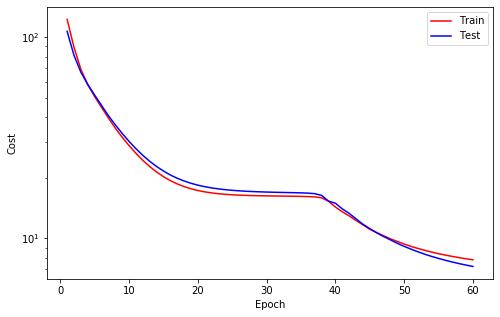



Epoch    61
Train_cost  = 7.7330 | Test_cost  = 7.1432 | 




Epoch    62
Train_cost  = 7.6541 | Test_cost  = 7.0464 | 




Epoch    63
Train_cost  = 7.5807 | Test_cost  = 6.9572 | 




Epoch    64
Train_cost  = 7.5125 | Test_cost  = 6.8747 | 




Epoch    65
Train_cost  = 7.4493 | Test_cost  = 6.7984 | 




Epoch    66
Train_cost  = 7.3907 | Test_cost  = 6.7274 | 




Epoch    67
Train_cost  = 7.3362 | Test_cost  = 6.6613 | 




Epoch    68
Train_cost  = 7.2853 | Test_cost  = 6.5996 | 




Epoch    69
Train_cost  = 7.2375 | Test_cost  = 6.5417 | 




Epoch    70
Train_cost  = 7.1926 | Test_cost  = 6.4874 | 




Epoch    71
Train_cost  = 7.1502 | Test_cost  = 6.4364 | 




Epoch    72
Train_cost  = 7.1103 | Test_cost  = 6.3883 | 




Epoch    73
Train_cost  = 7.0725 | Test_cost  = 6.3430 | 




Epoch    74
Train_cost  = 7.0367 | Test_cost  = 6.3001 | 




Epoch    75
Train_cost  = 7.0029 | Test_cost  = 6.2597 | 




Epoch    76
Train_cost  = 6.9709 | Test_cost  = 6.2214 | 




Epoch    77
Train_cost  = 6.9406 | Test_cost  = 6.1851 | 




Epoch    78
Train_cost  = 6.9118 | Test_cost  = 6.1507 | 




Epoch    79
Train_cost  = 6.8845 | Test_cost  = 6.1180 | 




Epoch    80
Train_cost  = 6.8586 | Test_cost  = 6.0869 | 


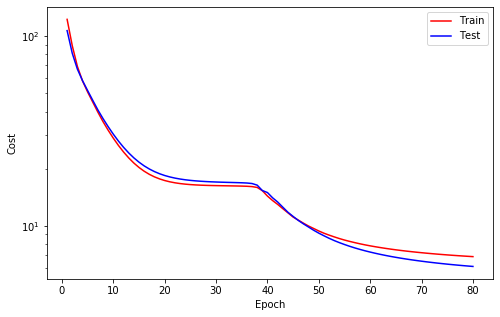



Epoch    81
Train_cost  = 6.8339 | Test_cost  = 6.0574 | 




Epoch    82
Train_cost  = 6.8104 | Test_cost  = 6.0293 | 




Epoch    83
Train_cost  = 6.7881 | Test_cost  = 6.0025 | 




Epoch    84
Train_cost  = 6.7668 | Test_cost  = 5.9769 | 




Epoch    85
Train_cost  = 6.7464 | Test_cost  = 5.9524 | 




Epoch    86
Train_cost  = 6.7270 | Test_cost  = 5.9291 | 




Epoch    87
Train_cost  = 6.7084 | Test_cost  = 5.9067 | 




Epoch    88
Train_cost  = 6.6906 | Test_cost  = 5.8853 | 




Epoch    89
Train_cost  = 6.6735 | Test_cost  = 5.8647 | 




Epoch    90
Train_cost  = 6.6572 | Test_cost  = 5.8450 | 




Epoch    91
Train_cost  = 6.6415 | Test_cost  = 5.8260 | 




Epoch    92
Train_cost  = 6.6264 | Test_cost  = 5.8077 | 




Epoch    93
Train_cost  = 6.6119 | Test_cost  = 5.7901 | 




Epoch    94
Train_cost  = 6.5979 | Test_cost  = 5.7731 | 




Epoch    95
Train_cost  = 6.5844 | Test_cost  = 5.7567 | 




Epoch    96
Train_cost  = 6.5713 | Test_cost  = 5.7408 | 




Epoch    97
Train_cost  = 6.5588 | Test_cost  = 5.7255 | 




Epoch    98
Train_cost  = 6.5466 | Test_cost  = 5.7106 | 




Epoch    99
Train_cost  = 6.5348 | Test_cost  = 5.6962 | 




Epoch   100
Train_cost  = 6.5234 | Test_cost  = 5.6823 | 


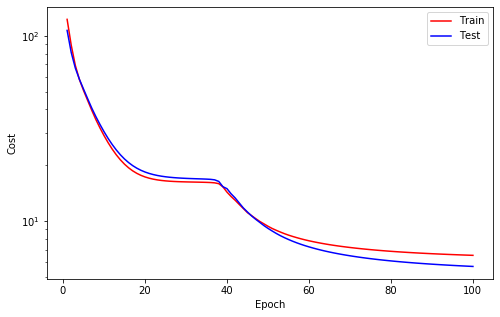



Epoch   101
Train_cost  = 6.5123 | Test_cost  = 5.6687 | 




Epoch   102
Train_cost  = 6.5016 | Test_cost  = 5.6556 | 




Epoch   103
Train_cost  = 6.4912 | Test_cost  = 5.6429 | 




Epoch   104
Train_cost  = 6.4811 | Test_cost  = 5.6305 | 




Epoch   105
Train_cost  = 6.4712 | Test_cost  = 5.6185 | 




Epoch   106
Train_cost  = 6.4616 | Test_cost  = 5.6068 | 




Epoch   107
Train_cost  = 6.4523 | Test_cost  = 5.5955 | 




Epoch   108
Train_cost  = 6.4432 | Test_cost  = 5.5845 | 




Epoch   109
Train_cost  = 6.4343 | Test_cost  = 5.5738 | 




Epoch   110
Train_cost  = 6.4257 | Test_cost  = 5.5635 | 




Epoch   111
Train_cost  = 6.4173 | Test_cost  = 5.5534 | 




Epoch   112
Train_cost  = 6.4090 | Test_cost  = 5.5436 | 




Epoch   113
Train_cost  = 6.4010 | Test_cost  = 5.5341 | 




Epoch   114
Train_cost  = 6.3931 | Test_cost  = 5.5249 | 




Epoch   115
Train_cost  = 6.3855 | Test_cost  = 5.5159 | 




Epoch   116
Train_cost  = 6.3780 | Test_cost  = 5.5071 | 




Epoch   117
Train_cost  = 6.3706 | Test_cost  = 5.4986 | 




Epoch   118
Train_cost  = 6.3635 | Test_cost  = 5.4904 | 




Epoch   119
Train_cost  = 6.3564 | Test_cost  = 5.4823 | 




Epoch   120
Train_cost  = 6.3496 | Test_cost  = 5.4745 | 


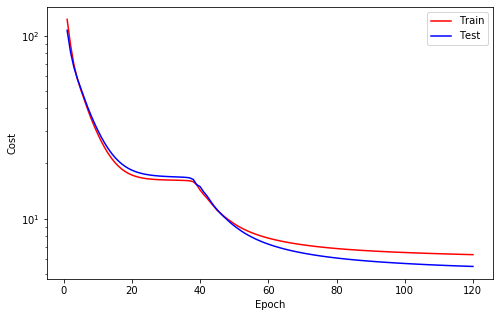



Epoch   121
Train_cost  = 6.3428 | Test_cost  = 5.4669 | 




Epoch   122
Train_cost  = 6.3362 | Test_cost  = 5.4595 | 




Epoch   123
Train_cost  = 6.3297 | Test_cost  = 5.4523 | 




Epoch   124
Train_cost  = 6.3234 | Test_cost  = 5.4452 | 




Epoch   125
Train_cost  = 6.3172 | Test_cost  = 5.4384 | 




Epoch   126
Train_cost  = 6.3110 | Test_cost  = 5.4317 | 




Epoch   127
Train_cost  = 6.3050 | Test_cost  = 5.4253 | 




Epoch   128
Train_cost  = 6.2991 | Test_cost  = 5.4190 | 




Epoch   129
Train_cost  = 6.2933 | Test_cost  = 5.4128 | 




Epoch   130
Train_cost  = 6.2876 | Test_cost  = 5.4068 | 




Epoch   131
Train_cost  = 6.2820 | Test_cost  = 5.4010 | 




Epoch   132
Train_cost  = 6.2764 | Test_cost  = 5.3954 | 




Epoch   133
Train_cost  = 6.2710 | Test_cost  = 5.3899 | 




Epoch   134
Train_cost  = 6.2656 | Test_cost  = 5.3845 | 




Epoch   135
Train_cost  = 6.2604 | Test_cost  = 5.3794 | 




Epoch   136
Train_cost  = 6.2552 | Test_cost  = 5.3743 | 




Epoch   137
Train_cost  = 6.2501 | Test_cost  = 5.3694 | 




Epoch   138
Train_cost  = 6.2450 | Test_cost  = 5.3647 | 




Epoch   139
Train_cost  = 6.2400 | Test_cost  = 5.3600 | 




Epoch   140
Train_cost  = 6.2351 | Test_cost  = 5.3555 | 


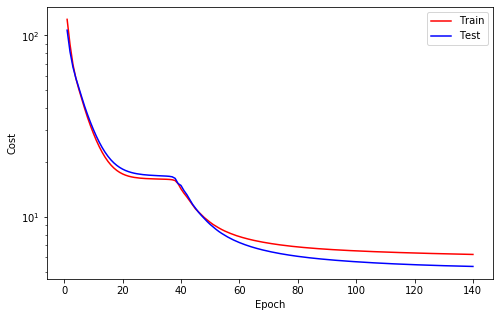



Epoch   141
Train_cost  = 6.2303 | Test_cost  = 5.3512 | 




Epoch   142
Train_cost  = 6.2255 | Test_cost  = 5.3470 | 




Epoch   143
Train_cost  = 6.2208 | Test_cost  = 5.3428 | 




Epoch   144
Train_cost  = 6.2161 | Test_cost  = 5.3389 | 




Epoch   145
Train_cost  = 6.2115 | Test_cost  = 5.3350 | 




Epoch   146
Train_cost  = 6.2070 | Test_cost  = 5.3312 | 




Epoch   147
Train_cost  = 6.2025 | Test_cost  = 5.3276 | 




Epoch   148
Train_cost  = 6.1980 | Test_cost  = 5.3241 | 




Epoch   149
Train_cost  = 6.1936 | Test_cost  = 5.3206 | 




Epoch   150
Train_cost  = 6.1892 | Test_cost  = 5.3173 | 




Epoch   151
Train_cost  = 6.1849 | Test_cost  = 5.3141 | 




Epoch   152
Train_cost  = 6.1807 | Test_cost  = 5.3110 | 




Epoch   153
Train_cost  = 6.1764 | Test_cost  = 5.3079 | 




Epoch   154
Train_cost  = 6.1722 | Test_cost  = 5.3050 | 




Epoch   155
Train_cost  = 6.1681 | Test_cost  = 5.3021 | 




Epoch   156
Train_cost  = 6.1639 | Test_cost  = 5.2994 | 




Epoch   157
Train_cost  = 6.1598 | Test_cost  = 5.2967 | 




Epoch   158
Train_cost  = 6.1558 | Test_cost  = 5.2941 | 




Epoch   159
Train_cost  = 6.1517 | Test_cost  = 5.2916 | 




Epoch   160
Train_cost  = 6.1477 | Test_cost  = 5.2891 | 


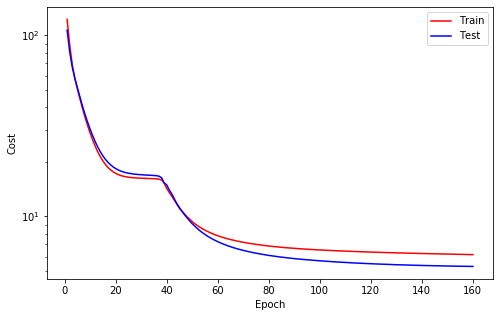



Epoch   161
Train_cost  = 6.1438 | Test_cost  = 5.2867 | 




Epoch   162
Train_cost  = 6.1398 | Test_cost  = 5.2844 | 




Epoch   163
Train_cost  = 6.1359 | Test_cost  = 5.2822 | 




Epoch   164
Train_cost  = 6.1320 | Test_cost  = 5.2800 | 




Epoch   165
Train_cost  = 6.1281 | Test_cost  = 5.2779 | 




Epoch   166
Train_cost  = 6.1242 | Test_cost  = 5.2758 | 




Epoch   167
Train_cost  = 6.1203 | Test_cost  = 5.2738 | 




Epoch   168
Train_cost  = 6.1165 | Test_cost  = 5.2719 | 




Epoch   169
Train_cost  = 6.1127 | Test_cost  = 5.2700 | 




Epoch   170
Train_cost  = 6.1088 | Test_cost  = 5.2682 | 




Epoch   171
Train_cost  = 6.1050 | Test_cost  = 5.2664 | 




Epoch   172
Train_cost  = 6.1012 | Test_cost  = 5.2646 | 




Epoch   173
Train_cost  = 6.0974 | Test_cost  = 5.2629 | 




Epoch   174
Train_cost  = 6.0936 | Test_cost  = 5.2613 | 




Epoch   175
Train_cost  = 6.0898 | Test_cost  = 5.2596 | 




Epoch   176
Train_cost  = 6.0860 | Test_cost  = 5.2581 | 




Epoch   177
Train_cost  = 6.0822 | Test_cost  = 5.2565 | 




Epoch   178
Train_cost  = 6.0784 | Test_cost  = 5.2550 | 




Epoch   179
Train_cost  = 6.0746 | Test_cost  = 5.2535 | 




Epoch   180
Train_cost  = 6.0708 | Test_cost  = 5.2520 | 


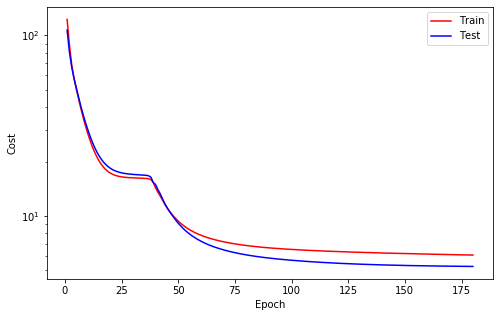



Epoch   181
Train_cost  = 6.0670 | Test_cost  = 5.2506 | 




Epoch   182
Train_cost  = 6.0632 | Test_cost  = 5.2492 | 




Epoch   183
Train_cost  = 6.0594 | Test_cost  = 5.2478 | 




Epoch   184
Train_cost  = 6.0555 | Test_cost  = 5.2465 | 




Epoch   185
Train_cost  = 6.0517 | Test_cost  = 5.2452 | 




Epoch   186
Train_cost  = 6.0478 | Test_cost  = 5.2439 | 




Epoch   187
Train_cost  = 6.0439 | Test_cost  = 5.2427 | 




Epoch   188
Train_cost  = 6.0401 | Test_cost  = 5.2414 | 




Epoch   189
Train_cost  = 6.0361 | Test_cost  = 5.2402 | 




Epoch   190
Train_cost  = 6.0322 | Test_cost  = 5.2390 | 




Epoch   191
Train_cost  = 6.0283 | Test_cost  = 5.2379 | 




Epoch   192
Train_cost  = 6.0243 | Test_cost  = 5.2368 | 




Epoch   193
Train_cost  = 6.0203 | Test_cost  = 5.2357 | 




Epoch   194
Train_cost  = 6.0163 | Test_cost  = 5.2346 | 




Epoch   195
Train_cost  = 6.0122 | Test_cost  = 5.2336 | 




Epoch   196
Train_cost  = 6.0082 | Test_cost  = 5.2326 | 




Epoch   197
Train_cost  = 6.0041 | Test_cost  = 5.2317 | 




Epoch   198
Train_cost  = 5.9999 | Test_cost  = 5.2308 | 




Epoch   199
Train_cost  = 5.9958 | Test_cost  = 5.2299 | 




Epoch   200
Train_cost  = 5.9915 | Test_cost  = 5.2291 | 


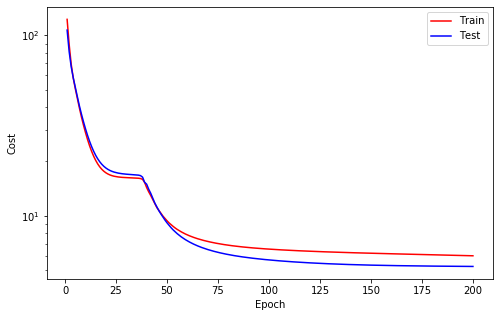



Epoch   201
Train_cost  = 5.9873 | Test_cost  = 5.2283 | 




Epoch   202
Train_cost  = 5.9830 | Test_cost  = 5.2276 | 




Epoch   203
Train_cost  = 5.9786 | Test_cost  = 5.2269 | 




Epoch   204
Train_cost  = 5.9742 | Test_cost  = 5.2263 | 




Epoch   205
Train_cost  = 5.9698 | Test_cost  = 5.2258 | 




Epoch   206
Train_cost  = 5.9653 | Test_cost  = 5.2254 | 




Epoch   207
Train_cost  = 5.9607 | Test_cost  = 5.2250 | 




Epoch   208
Train_cost  = 5.9561 | Test_cost  = 5.2247 | 




Epoch   209
Train_cost  = 5.9514 | Test_cost  = 5.2246 | 




Epoch   210
Train_cost  = 5.9467 | Test_cost  = 5.2245 | 




Epoch   211
Train_cost  = 5.9419 | Test_cost  = 5.2245 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2245




Epoch   212
Train_cost  = 5.9370 | Test_cost  = 5.2247 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2245




Epoch   213
Train_cost  = 5.9320 | Test_cost  = 5.2250 | 
==> EarlyStop patience =  3 | Best test_cost: 5.2245




Epoch   214
Train_cost  = 5.9270 | Test_cost  = 5.2254 | 
==> EarlyStop patience =  4 | Best test_cost: 5.2245




Epoch   215
Train_cost  = 5.9219 | Test_cost  = 5.2260 | 
==> EarlyStop patience =  5 | Best test_cost: 5.2245
==> Execute Early Stopping at epoch: 215 | Best test_cost: 5.2245
==> Best model is saved at model/rnn


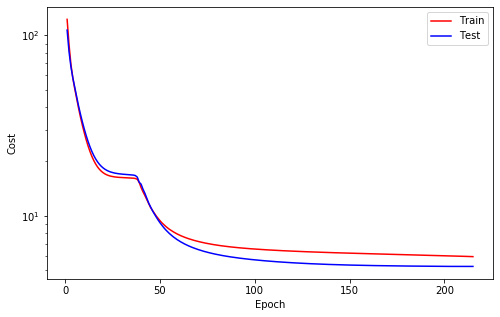

In [12]:
# training 
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging 
    callback.log(train_cost, test_cost)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [15]:
# import package
from utils import data4pred, pred4pred

In [16]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

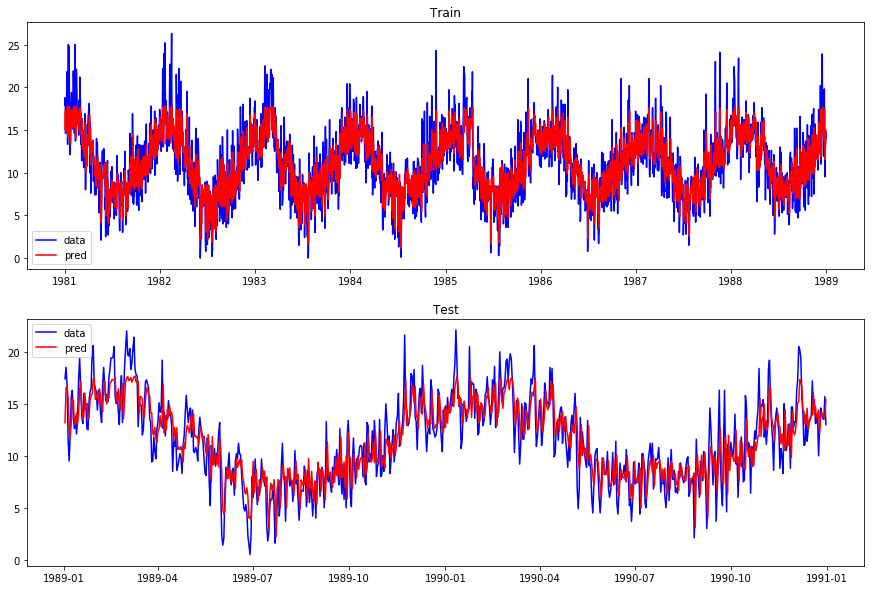

In [17]:
# Data for pred

plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

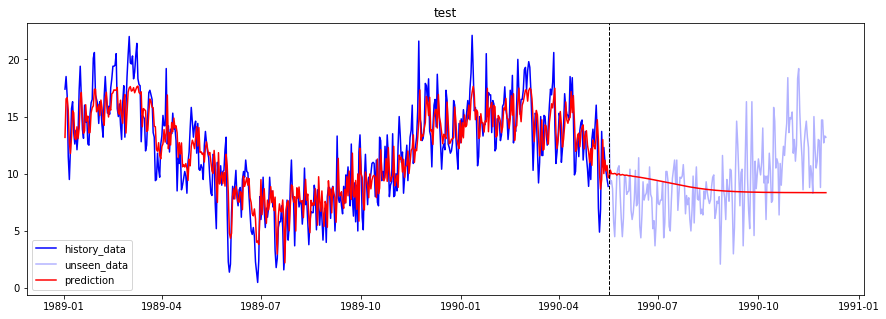

In [18]:
# Pred for Pred

plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")